# Event Study Assignment - Choi

### Import Packages & Load Files & Set Date

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
ff_daily = pd.read_csv("ff_daily.csv")
stock_splits = pd.read_csv("stock_splits.csv")
df_stock = pd.read_csv("stock_daily.csv").dropna()

In [3]:
# Adjusting dates to same format using pd.to_datetime from pandas

ff_daily['Date'] = pd.to_datetime(ff_daily['Date'], format='%Y%m%d').astype('datetime64[D]')
stock_splits['disdeclaredt'] = pd.to_datetime(stock_splits['disdeclaredt'], format="%m/%d/%Y").astype('datetime64[D]')
stock_splits['disrecorddt'] = pd.to_datetime(stock_splits['disrecorddt'], format="%m/%d/%Y").astype('datetime64[D]')
stock_splits['dispaydt'] = pd.to_datetime(stock_splits['dispaydt'], format="%m/%d/%Y").astype('datetime64[D]')
stock_splits['disexdt'] = pd.to_datetime(stock_splits['disexdt'], format="%m/%d/%Y").astype('datetime64[D]')
df_stock['dlycaldt'] = pd.to_datetime(df_stock['dlycaldt'], format='%Y-%m-%d').astype('datetime64[D]')

### Merge Data & Check Mismatching Obs

In [4]:
# Make MKT Index Return in our FF dataset
ff_daily['index_return'] = (ff_daily['Mkt-RF'] + ff_daily['RF'])/100

# Merge df_stock and ff_daily based on the date columns
merged_df = pd.merge(df_stock, ff_daily[['Date', 'index_return']], left_on='dlycaldt', right_on='Date', how='left')

# Create the "abret" column by subtracting index_return from dlyret
merged_df['abret'] = merged_df['dlyret'] - merged_df['index_return']

# Drop the extra 'Date' column from dataset ff_daily if not needed
merged_df = merged_df.drop(columns=['Date'])

# Merge the datasets on 'permno' and matching the dates 'disdeclaredt' and 'dlycaldt'
merged_df = pd.merge(merged_df, stock_splits[['permno', 'disdeclaredt']], 
                                 left_on=['permno', 'dlycaldt'], 
                                 right_on=['permno', 'disdeclaredt'], 
                                 how='left')

# Drop 'disdeclaredt' after the merge, if you don't need it anymore
merged_df = merged_df.drop(columns=['disdeclaredt'])

In [5]:
# Check any mis-matching data

for i, row in stock_splits.iterrows():
    permno = row['permno']
    split_date = row['disdeclaredt']
    
    stock_data = merged_df[merged_df['permno'] == permno].sort_values('dlycaldt')
    trading_days = stock_data['dlycaldt'].values
    
    # Check whether stock_split has stocks that has no data in CRSP
    if len(trading_days) == 0: 
        print(f"Permno {permno}: No trading data found.")
        continue 

    # Check whether the split date is not on a trading date (Weekends)
    if split_date not in trading_days:
        closest_trading_date = min(trading_days, key=lambda x: abs(x - split_date)).astype('datetime64[D]')
        print(f"Permno {permno}: Split date {split_date} not a trading day. Nearest trading day: {closest_trading_date}")


Permno 92044: No trading data found.
Permno 85992: Split date 2013-12-19 00:00:00 not a trading day. Nearest trading day: 2014-01-02
Permno 65294: Split date 2013-11-14 00:00:00 not a trading day. Nearest trading day: 2014-01-02
Permno 91233: Split date 2013-12-10 00:00:00 not a trading day. Nearest trading day: 2014-01-02
Permno 92557: No trading data found.
Permno 93106: No trading data found.
Permno 91954: No trading data found.
Permno 92778: No trading data found.
Permno 91983: No trading data found.
Permno 92611: No trading data found.
Permno 92432: No trading data found.
Permno 93312: No trading data found.
Permno 92797: No trading data found.
Permno 93356: No trading data found.
Permno 93436: No trading data found.
Permno 16309: Split date 2021-05-08 00:00:00 not a trading day. Nearest trading day: 2021-05-07
Permno 14714: Split date 2021-10-30 00:00:00 not a trading day. Nearest trading day: 2021-10-29


### Find Average CAR Value using MKT Index & Regression

#### Example of constructing windows

In [6]:
# Lets consider one permno code here
permno = 68830
split_date = stock_splits.loc[stock_splits['permno'] == 68830, 'disdeclaredt'].iloc[0]

# We can see our split date is 2022-06-21
split_date 

Timestamp('2022-06-21 00:00:00')

In [7]:
# Now we consider the total trading days for this stock 
stock_data = merged_df[merged_df['permno'] == permno].sort_values('dlycaldt')
trading_days = stock_data['dlycaldt'].values

# We then want to see if out split date is in the trading day range
if split_date in trading_days:
    closest_trading_date = split_date
else:  # Find the closest trading day to the split date if split date is not trading day
    closest_trading_date = min(trading_days, key=lambda x: abs(x - split_date))
    delta_days = (closest_trading_date - split_date).days
        
closest_trading_date = split_date

# Yes it is in the trading day range
closest_trading_date

Timestamp('2022-06-21 00:00:00')

In [8]:
# Now we find the index of the split date to calculate the +1 & -1 window
# This function gives us the index of split day in list of trading days
split_index = np.where(trading_days == closest_trading_date)[0][0] # This value is 2132

# Now we consider the window (which is the hyperparameter of this function)
window_size = 1

# We not set the start and end index
# Note that max() is used for if split date is the 1st obs of trading days for 68830
# Note that min() is used for if split date is the last obs of trading days for 68830
start_index = max(0, split_index - window_size) 
end_index = min(len(trading_days), split_index + window_size)

# We then set the window which is -1 day before stock split and +1 day after the stock split
window = stock_data.iloc[start_index:end_index + 1]

window

,permno,ticker,siccd,yyyymmdd,dlycaldt,dlyprc,dlycap,dlyret,dlyfacprc,shrout,index_return,abret
5439406,68830,REX,2869,20220617,2022-06-17,84.660004,501187.2,0.000591,1.0,5920,0.00463,-0.004039
5439407,68830,REX,2869,20220621,2022-06-21,87.739998,519420.8,0.036381,1.0,5920,0.02383,0.012551
5439408,68830,REX,2869,20220622,2022-06-22,82.360001,487571.2,-0.061318,1.0,5920,-0.00187,-0.059448


In [9]:
# Now consider the Abnormal Return (Method 1)
car_value = window['abret'].sum() 

# Make a column called car1 in our merged_df and insert our car_value in the split day
merged_df.loc[(merged_df['permno'] == permno) & (merged_df['dlycaldt'] == closest_trading_date), f'car{window_size}'] = car_value
merged_df[merged_df[f'car{window_size}'].notna()]

,permno,ticker,siccd,yyyymmdd,dlycaldt,dlyprc,dlycap,dlyret,dlyfacprc,shrout,index_return,abret,car1
5439407,68830,REX,2869,20220621,2022-06-21,87.739998,519420.8,0.036381,1.0,5920,0.02383,0.012551,-0.050936


In [10]:
# Now consider the Regression Method (Method 2)
# Define pre-event windw as -250 to -50 days 
pre_event_window = stock_data.iloc[max(0, split_index - 250):max(0, split_index - 50)]
pre_event_window

,permno,ticker,siccd,yyyymmdd,dlycaldt,dlyprc,dlycap,dlyret,dlyfacprc,shrout,index_return,abret
5439157,68830,REX,2869,20210623,2021-06-23,95.650002,573134.80,-0.011472,1.0,5992,0.00010,-0.011572
5439158,68830,REX,2869,20210624,2021-06-24,96.279999,576909.76,0.006587,1.0,5992,0.00690,-0.000313
5439159,68830,REX,2869,20210625,2021-06-25,92.260002,552821.92,-0.041753,1.0,5992,0.00320,-0.044953
5439160,68830,REX,2869,20210628,2021-06-28,90.589996,542815.28,-0.018101,1.0,5992,0.00220,-0.020301
5439161,68830,REX,2869,20210629,2021-06-29,92.580002,554739.36,0.021967,1.0,5992,0.00000,0.021967
...,...,...,...,...,...,...,...,...,...,...,...,...
5439352,68830,REX,2869,20220331,2022-03-31,99.599998,589632.00,-0.011807,1.0,5920,-0.01550,0.003693
5439353,68830,REX,2869,20220401,2022-04-01,102.430000,606385.60,0.028414,1.0,5920,0.00391,0.024504
5439354,68830,REX,2869,20220404,2022-04-04,97.830002,579153.60,-0.044909,1.0,5920,0.00941,-0.054319
5439355,68830,REX,2869,20220405,2022-04-05,95.320000,564294.40,-0.025657,1.0,5920,-0.01549,-0.010167


In [11]:
# If number of obs in pre-event window is geq 200, we estimate abnormal return by ols
if len(pre_event_window) >= 200: # True
                X = sm.add_constant(pre_event_window['index_return']) # X is market index return R_mt
                y = pre_event_window['dlyret'] # Y is stock return R_it
                model = sm.OLS(y, X).fit()

                alpha = model.params['const']
                beta = model.params['index_return']
                
                # Estimate abnormal returns : AR_it = R_it - (a + b*R_mt)
                stock_data['abret_estimated'] = stock_data['dlyret'] - (alpha + beta * stock_data['index_return'])
                
                # Re-define the window for estimated abnormal returns
                window = stock_data.iloc[start_index:end_index + 1]
                window = window[window['abret_estimated'].notna()]
                car_value = window['abret_estimated'].sum()

# Make a column called car_estimated1 in our merged_df and insert our car_value in the split day
merged_df.loc[(merged_df['permno'] == permno) & (merged_df['dlycaldt'] == closest_trading_date), f'car_estimated{window_size}'] = car_value
merged_df[merged_df[f'car_estimated{window_size}'].notna()]

,permno,ticker,siccd,yyyymmdd,dlycaldt,dlyprc,dlycap,dlyret,dlyfacprc,shrout,index_return,abret,car1,car_estimated1
5439407,68830,REX,2869,20220621,2022-06-21,87.739998,519420.8,0.036381,1.0,5920,0.02383,0.012551,-0.050936,-0.046163


#### Main Function

In [12]:
# Function to calculate CAR
def calculate_car(window_size, method='abnormal'):
    for i, row in stock_splits.iterrows():
        permno = row['permno']
        split_date = row['disdeclaredt']

        stock_data = merged_df[merged_df['permno'] == permno].sort_values('dlycaldt')
        trading_days = stock_data['dlycaldt'].values

        if len(trading_days) == 0:  # Skip if no trading data found for this permno
            continue

        if split_date in trading_days:
            closest_trading_date = split_date
        else:  # Find the closest trading day to the split date if split date is not trading day
            closest_trading_date = min(trading_days, key=lambda x: abs(x - split_date))
            delta_days = (closest_trading_date - split_date).days
            if abs(delta_days) > 2:  # Skip if the nearest trading day is more than 2 days away
                continue

        # This function gives us the index of split day in list of trading days
        split_index = np.where(trading_days == closest_trading_date)[0][0]

        # Define window: - window_size to + window_size days from the split index
        start_index = max(0, split_index - window_size)
        end_index = min(len(trading_days), split_index + window_size)

        window = stock_data.iloc[start_index:end_index + 1]

        # Method 1: Abnormal returns from MKT Index
        if method == 'abnormal':
            car_value = window['abret'].sum()

        # Method 2: Regression-based CAR (MKT Model)
        elif method == 'regression':
            pre_event_window = stock_data.iloc[max(0, split_index - 250):max(0, split_index - 50)]
            
            if len(pre_event_window) >= 200:  # 200 obs for regression
                X = sm.add_constant(pre_event_window['index_return'])
                y = pre_event_window['dlyret']
                model = sm.OLS(y, X).fit()

                alpha = model.params['const']
                beta = model.params['index_return']
                
                # Estimate abnormal returns using the market index model
                stock_data['abret_estimated'] = stock_data['dlyret'] - (alpha + beta * stock_data['index_return'])
                
                # Re-define the window for estimated abnormal returns
                window = stock_data.iloc[start_index:end_index + 1]
                window = window[window['abret_estimated'].notna()]
                car_value = window['abret_estimated'].sum()
            else:
                # Skip this permno if we do not have 200 obs
                continue

        # Update the car value for the split day (closest trading day)
        if method == 'abnormal':
            merged_df.loc[(merged_df['permno'] == permno) & 
                          (merged_df['dlycaldt'] == closest_trading_date), f'car{window_size}'] = car_value
        else:
            merged_df.loc[(merged_df['permno'] == permno) & 
                          (merged_df['dlycaldt'] == closest_trading_date), f'car_estimated{window_size}'] = car_value


In [13]:
# Now let's run the model

# List of window sizes to iterate 
window_sizes = [1, 3, 10]

summary_table = pd.DataFrame(columns=['Model', 'Window', 'Coef', 'Std Err', 't-value', 'P-value', 'N'])

# Run CAR function for both methods and all window sizes
for window_size in window_sizes:

    # Reset car columns to NaN for each window size
    merged_df[f'car{window_size}'] = np.nan
    merged_df[f'car_estimated{window_size}'] = np.nan

    # Method 1: MKT Index-based CAR
    calculate_car(window_size, method='abnormal')
    merged_df_1 = merged_df[~(merged_df[f'car{window_size}'].isna())]
    X = sm.add_constant(np.ones(len(merged_df_1)))
    y = merged_df_1[f'car{window_size}']
    model_1 = sm.OLS(y, X).fit()

    summary_table = summary_table.append({
        'Model': 'Simple AR',
        'Window': f'-{window_size} to +{window_size}',
        'Coef': model_1.params[0],
        'Std Err': model_1.bse[0],
        't-value': model_1.tvalues[0],
        'P-value': model_1.pvalues[0],
        'N': int(model_1.nobs)
    }, ignore_index=True)

    # Method 2: Regression-based CAR
    calculate_car(window_size, method='regression')
    merged_df_2 = merged_df[~(merged_df[f'car_estimated{window_size}'].isna())]
    X = sm.add_constant(np.ones(len(merged_df_2)))
    y = merged_df_2[f'car_estimated{window_size}']
    model_2 = sm.OLS(y, X).fit()

    summary_table = summary_table.append({
        'Model': 'Regression Based',
        'Window': f'-{window_size} to +{window_size}',
        'Coef': model_2.params[0],
        'Std Err': model_2.bse[0],
        't-value': model_2.tvalues[0],
        'P-value': model_2.pvalues[0],
        'N': int(model_2.nobs)
    }, ignore_index=True)

    # Method 3: Abnormal Comparison
    merged_df_3 = merged_df[~(merged_df[f'car_estimated{window_size}'].isna())] # Note that N-obs are from Method 2
    X = sm.add_constant(np.ones(len(merged_df_3)))
    y = merged_df_3[f'car{window_size}']  # Use CAR from the MKT Index method
    model_3 = sm.OLS(y, X).fit()

    summary_table = summary_table.append({
        'Model': 'Simple AR Comparison',
        'Window': f'-{window_size} to +{window_size}',
        'Coef': model_3.params[0],
        'Std Err': model_3.bse[0],
        't-value': model_3.tvalues[0],
        'P-value': model_3.pvalues[0],
        'N': int(model_3.nobs)
    }, ignore_index=True)


In [14]:
summary_table

,Model,Window,Coef,Std Err,t-value,P-value,N
0,Simple AR,-1 to +1,0.007622,0.004644,1.641095,0.103510,116
1,Regression Based,-1 to +1,0.002873,0.006052,0.474778,0.636239,81
2,Simple AR Comparison,-1 to +1,0.004441,0.006071,0.731437,0.466649,81
3,Simple AR,-3 to +3,0.018761,0.006969,2.691945,0.008164,116
4,Regression Based,-3 to +3,0.010390,0.008957,1.159896,0.249541,81
5,Simple AR Comparison,-3 to +3,0.015734,0.009203,1.709655,0.091206,81
6,Simple AR,-10 to +10,0.022920,0.009712,2.359950,0.019962,116
7,Regression Based,-10 to +10,0.009829,0.012278,0.800535,0.425772,81
8,Simple AR Comparison,-10 to +10,0.031964,0.012808,2.495692,0.014628,81


### Cross-sectional Test on Stock Split Effects

In [15]:
# To conduct cross-sectional test on stock splits, we first make a new dataframe and merge with 'disfacshr' in stock split
merged_df_4 = pd.merge(merged_df_1, stock_splits[['permno', 'disdeclaredt', 'disfacshr']], 
                       left_on=['permno', 'dlycaldt'], 
                       right_on=['permno', 'disdeclaredt'], how='left')

# Note that there are 2 missing 'disfacshr' values since there were 2 stocks which had split day not on a trading day
merged_df_4[merged_df_4['disfacshr'].isna()]

,permno,ticker,siccd,yyyymmdd,dlycaldt,dlyprc,dlycap,dlyret,dlyfacprc,shrout,index_return,abret,car1,car_estimated1,car3,car_estimated3,car10,car_estimated10,disdeclaredt,disfacshr
15,14714,ANET,3577,20211029,2021-10-29,409.69000,31430187.73,0.006510,1.0,76717,0.0022,0.004310,-0.004373,-0.012047,0.284374,0.272069,0.252033,NaN,NaT,NaN
20,16309,TTD,9999,20210507,2021-05-07,661.42999,28458025.75,0.080238,1.0,43025,0.0084,0.071838,-0.221142,-0.229503,-0.241161,-0.249382,-0.206324,NaN,NaT,NaN


In [16]:
# Update the disfacshr column for specific permnos
merged_df_4.loc[merged_df_4['permno'] == 14714, 'disfacshr'] = 3.0
merged_df_4.loc[merged_df_4['permno'] == 16309, 'disfacshr'] = 9.0

# When we check again we don't have any missing values
merged_df_4['disfacshr'].isna().sum()

0

In [17]:
# Testing the Split Factor
X = merged_df_4['disfacshr']
X = sm.add_constant(X)
y = merged_df_4['car1']
model_4 = sm.OLS(y, X).fit()

# We can see negative effects with significance
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                   car1   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     5.054
Date:                Tue, 01 Oct 2024   Prob (F-statistic):             0.0265
Time:                        18:29:08   Log-Likelihood:                 185.88
No. Observations:                 116   AIC:                            -367.8
Df Residuals:                     114   BIC:                            -362.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0198      0.007      2.795      0.0

### Cross-sectional Test on MKT Capitalization

In [18]:
# Testing for MKT Cap
X = np.log(merged_df_4['dlycap'])
X = sm.add_constant(X)
y = merged_df_4['car1']
model_5 = sm.OLS(y, X).fit()

# We can see positive effects but not significant
print(model_5.summary())

                            OLS Regression Results                            
Dep. Variable:                   car1   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.650
Date:                Tue, 01 Oct 2024   Prob (F-statistic):             0.0586
Time:                        18:29:08   Log-Likelihood:                 185.19
No. Observations:                 116   AIC:                            -366.4
Df Residuals:                     114   BIC:                            -360.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0587      0.035     -1.676      0.0

### Plot CAAR from -30 to +30 Window

Text(0.5, 1.0, 'Cumulative Average Abnormal Returns (CAAR)')

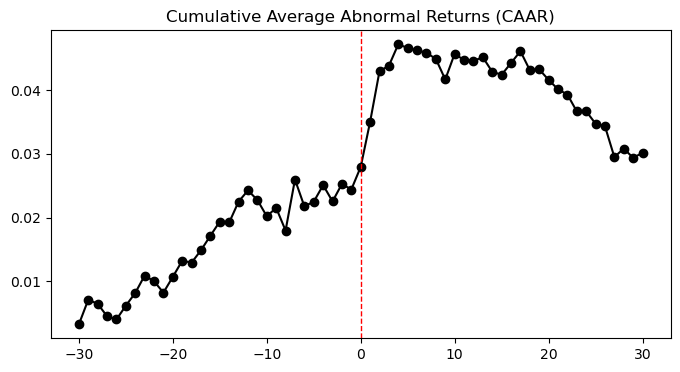

In [19]:
event_window = list(range(-30, 31)) # 60 days
event_abnormal_returns = {day: [] for day in event_window}

for i, split in stock_splits.iterrows():
    permno = split['permno']
    split_date = split['disdeclaredt']
    
    stock_data = merged_df[merged_df['permno'] == permno].reset_index()
    
    if split_date in stock_data['dlycaldt'].values:
        split_index = stock_data[stock_data['dlycaldt'] == split_date].index[0]
        
        for day in event_window:
            event_day_index = split_index + day

            if event_day_index >= 0 and event_day_index < len(stock_data):
                event_abnormal_returns[day].append(stock_data.loc[event_day_index, 'abret'])

avg_abnormal_returns = {day: np.nanmean(event_abnormal_returns[day]) for day in event_window}

caar_values = []
cumulative_return = 0 
for day in event_window:
    cumulative_return += avg_abnormal_returns[day]  
    caar_values.append(cumulative_return) 

caar_df = pd.DataFrame({
    'event_day': event_window,
    'caar': caar_values
})

plt.figure(figsize=(8, 4))
plt.plot(caar_df['event_day'], caar_df['caar'], marker='o', linestyle='-', color='black', label='CAAR')
plt.axvline(0, color='red', linestyle='--', linewidth=1) 
plt.title('Cumulative Average Abnormal Returns (CAAR)')

Text(0.5, 1.0, 'Cumulative Average Abnormal Returns (CAAR)')

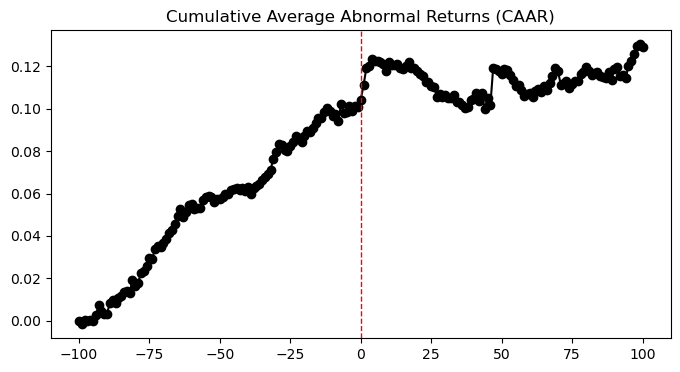

In [20]:
event_window = list(range(-100, 101)) # 200 days
event_abnormal_returns = {day: [] for day in event_window}

for i, split in stock_splits.iterrows():
    permno = split['permno']
    split_date = split['disdeclaredt']
    
    stock_data = merged_df[merged_df['permno'] == permno].reset_index()
    
    if split_date in stock_data['dlycaldt'].values:
        split_index = stock_data[stock_data['dlycaldt'] == split_date].index[0]
        
        for day in event_window:
            event_day_index = split_index + day

            if event_day_index >= 0 and event_day_index < len(stock_data):
                event_abnormal_returns[day].append(stock_data.loc[event_day_index, 'abret'])

avg_abnormal_returns = {day: np.nanmean(event_abnormal_returns[day]) for day in event_window}

caar_values = []
cumulative_return = 0 
for day in event_window:
    cumulative_return += avg_abnormal_returns[day]  
    caar_values.append(cumulative_return) 


caar_df = pd.DataFrame({
    'event_day': event_window,
    'caar': caar_values
})


plt.figure(figsize=(8, 4))
plt.plot(caar_df['event_day'], caar_df['caar'], marker='o', linestyle='-', color='black', label='CAAR')
plt.axvline(0, color='red', linestyle='--', linewidth=1) 
plt.title('Cumulative Average Abnormal Returns (CAAR)')
